# Intro to NBA Data with nba_api pt 4
## Let's learn about the capabilities of the `teams` module AND incorporate some more complexity into our visualizations. 

This is a simliar concept to part 3, except that it will use teams and plot win/loss vs other teams since the database begins. 



In [68]:
#import our modules and whatnot from nba_api and others as needed
from nba_api.stats.static import teams
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import SeasonAll 


We first ask the user for a team:

In [69]:
valid_input = False
#loop until valid input
while not valid_input:
    try:
        team_name = input("Please enter the full name of an NBA player: ")
        #first list index is the dict w/id, name, and activity status
        team = teams.find_teams_by_full_name(team_name)[0]
        # If the above line doesn't raise an IndexError, the input is valid
        valid_input = True
    except IndexError: 
        print("Invalid entry. Type an NBA team's full name(eg. 'Golden State Warriors'), separated by space(s).")
print(f"Good choice! You chose the {team['full_name']}!")

Good choice! You chose the Brooklyn Nets!


Then we call up that team's game logs since the beginning of the database:

In [70]:
#call the class on the leaguegamefinder module
team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable = team['id'],league_id_nullable='00')
#return the first element (dataframe)
team_games_df = team_games.get_data_frames()[0]
team_games_df.sample(10)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
546,22017,1610612751,BKN,Brooklyn Nets,0021700147,2017-11-06,BKN @ PHX,W,240,98,...,0.690,11,37,48,20,10,4,16,30,6.0
902,22013,1610612751,BKN,Brooklyn Nets,0021300327,2013-12-12,BKN vs. LAC,W,240,102,...,0.933,5,37,42,18,5,0,13,31,9.0
22,22023,1610612751,BKN,Brooklyn Nets,0022300149,2023-11-06,BKN vs. MIL,L,241,125,...,0.846,11,35,46,22,2,4,8,16,-4.0
1106,22010,1610612751,NJN,New Jersey Nets,0021001055,2011-03-23,NJN @ CLE,W,266,98,...,0.757,19,37,56,20,8,5,13,26,4.0
669,22015,1610612751,BKN,Brooklyn Nets,0021500896,2016-03-01,BKN @ LAL,L,240,101,...,0.667,11,33,44,28,8,4,7,19,-6.0
2168,21999,1610612751,NJN,New Jersey Nets,0029900530,2000-01-17,NJN @ PHI,L,239,96,...,0.708,11,25,36,21,10,6,16,27,-5.0
64,22022,1610612751,BKN,Brooklyn Nets,0022200833,2023-02-09,BKN vs. CHI,W,240,116,...,0.840,11,38,49,26,8,1,11,20,11.0
1499,22006,1610612751,NJN,New Jersey Nets,0020600667,2007-01-29,NJN @ UTA,W,236,116,...,0.811,5,16,21,24,11,3,9,26,1.0
905,22013,1610612751,BKN,Brooklyn Nets,0021300277,2013-12-05,BKN vs. NYK,L,241,83,...,0.677,15,20,35,11,3,3,16,25,-30.0
769,22014,1610612751,BKN,Brooklyn Nets,0021400849,2015-02-25,BKN @ NOP,L,240,96,...,0.733,8,29,37,13,6,6,12,16,-6.0


Then we find the results of certain matchups:

In [71]:
matchup_results = (team_games_df.groupby('MATCHUP')
                    ['WL']
                    .value_counts()
                    .reset_index(name = 'Wins/Losses')
                    )
matchup_results




,MATCHUP,WL,Wins/Losses
0,BKN @ ATL,L,13
1,BKN @ ATL,W,11
2,BKN @ BOS,L,21
3,BKN @ BOS,W,12
4,BKN @ CHA,W,11
...,...,...,...
268,NJN vs. UTH,W,5
269,NJN vs. VAN,W,4
270,NJN vs. VAN,L,1
271,NJN vs. WAS,W,40


And change the shape of this dataframe so that the opponents can become their own column, allowing us to group the results by opponent:

In [72]:
# Pivoting the DataFrame to get wins and losses columns for each team
team_wins_losses = (matchup_results.pivot(index='MATCHUP', columns='WL', values='Wins/Losses')
                    .reset_index()
                    .rename_axis(None, axis=1)
                    .rename(columns={'W': 'Wins', 'L': 'Losses'})
                    )

# Splitting the 'MATCHUP' column separately by 'vs.' or '@'
split_matches = matchup_results['MATCHUP'].str.split(r'\s(vs\.|@)\s', expand=True)

# Creating 'Team 1' and 'Team 2' columns
team_wins_losses['Team 1'] = split_matches[0]
team_wins_losses['Team 2'] = split_matches[2]

# Convert NaN values in 'Wins' and 'Losses' columns to 0s
team_wins_losses['Wins'] = team_wins_losses['Wins'].fillna(0)
team_wins_losses['Losses'] = team_wins_losses['Losses'].fillna(0)

# Rearranging columns to match the desired output
team_wins_losses = team_wins_losses[['Team 1', 'Team 2', 'Wins', 'Losses']]

team_wins_losses.sample(20)


,Team 1,Team 2,Wins,Losses
80,BKN,HOU,4.0,6.0
6,BKN,CHI,6.0,6.0
17,BKN,GSW,1.0,0.0
78,BKN,GSW,10.0,18.0
1,BKN,ATL,12.0,21.0
104,BKN,ORL,32.0,44.0
119,BKN,UTA,1.0,0.0
64,BKN,CHA,14.0,45.0
27,BKN,MEM,9.0,20.0
84,BKN,LAC,3.0,5.0


Let' show these results in a table of Wins and Losses:

In [73]:

# Create a new DataFrame to aggregate wins and losses for each 'Team 2' against 'Team 1'
team_results = pd.DataFrame()

# Group by 'Team 2' and aggregate wins and losses against 'Team 1'
team_results['Wins'] = team_wins_losses.groupby('Team 2')['Losses'].sum()
team_results['Losses'] = team_wins_losses.groupby('Team 2')['Wins'].sum()

# Reset index to make 'Team 2' a column instead of the index
team_results.reset_index(inplace=True)
team_results.rename(columns={'Team 2': 'Team'}, inplace=True)

# Fill NaN values with 0
team_results.fillna(0, inplace=True)

team_results

,Team,Wins,Losses
0,ATL,75.0,95.0
1,BOS,51.0,44.0
2,CHA,107.0,86.0
3,CHH,43.0,40.0
4,CHI,102.0,90.0
5,CLE,107.0,57.0
6,DAL,108.0,49.0
7,DEN,97.0,48.0
8,DET,69.0,61.0
9,FEN,22.0,6.0


And now a barplot:

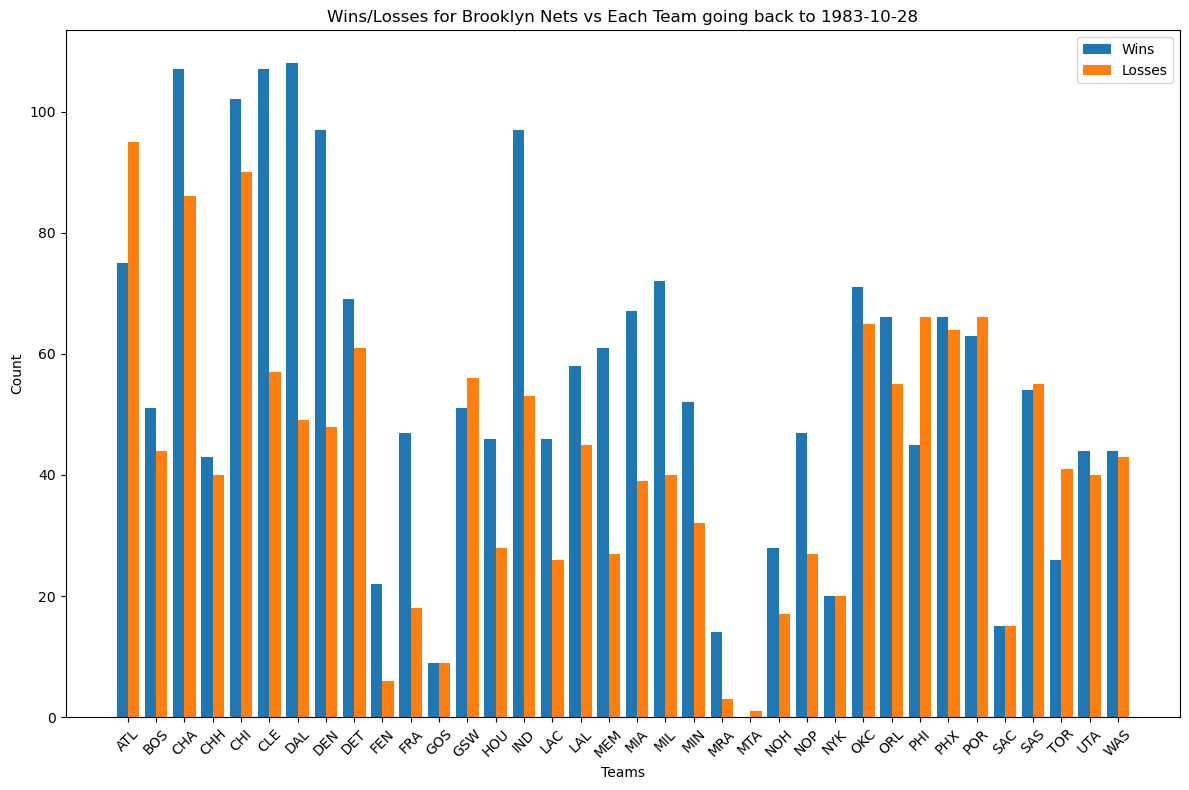

In [74]:

# Grouping by 'Team' and calculating total wins and losses for each team
grouped = team_results.groupby('Team').agg({'Wins': 'sum', 'Losses': 'sum'})

# Resetting index to access 'Team' as a column
grouped = grouped.reset_index()

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create positions for each team on the x-axis
x = range(len(grouped))

# Plotting the barplot for Wins and Losses
plt.bar(x, grouped['Wins'], width=0.4, align='center', label='Wins')
plt.bar([i + 0.4 for i in x], grouped['Losses'], width=0.4, align='center', label='Losses')

# Set x-axis labels to team names
plt.xticks([i + 0.2 for i in x], grouped['Team'], rotation = 45)

# Add labels and title
plt.xlabel('Teams')
plt.ylabel('Count')
plt.title(f'Wins/Losses for {team["full_name"]} vs Each Team going back to {team_games_df.GAME_DATE.min()}')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()